#Stock Market Prediction using SVM and LSTM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import warnings
warnings.filterwarnings('ignore')


## Load and Prepare Data

In [ ]:
df = pd.read_csv('NIFTY_50.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
print(df.head())


               Open     High      Low   Close    P/E   P/B Div Yield %
Date                                                                  
2000-01-03  1482.15  1592.90  1482.15  1592.2  25.91  4.63        0.95
2000-01-04  1594.40  1641.95  1594.40  1638.7  26.67  4.76        0.92
2000-01-05  1634.55  1635.50  1555.05  1595.8  25.97  4.64        0.95
2000-01-06  1595.80  1639.00  1595.80  1617.6  26.32  4.70        0.94
2000-01-07  1616.60  1628.25  1597.20  1613.3  26.25  4.69        0.94


##Support Vector Machine (SVM) - Next Day Close Price Prediction

📉 SVM Evaluation:
MAE: 10123.8970
MSE: 115525850.9592
RMSE: 10748.2953
R² Score: -9.7941


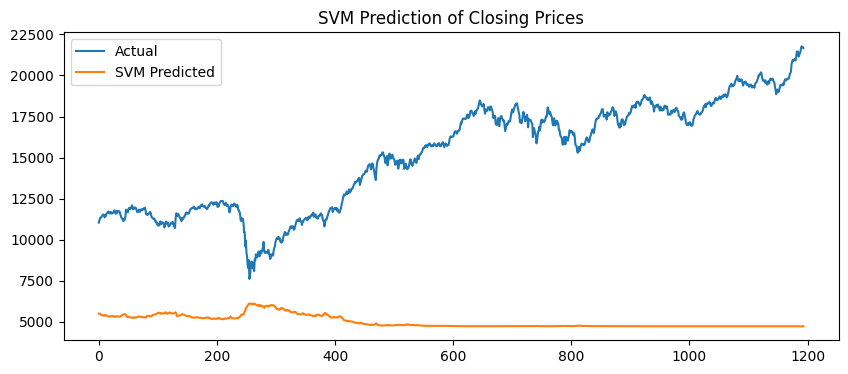

In [ ]:
# SVM uses previous day's OHLC to predict today's close
X = df[['Open', 'High', 'Low', 'Close']].shift(1).dropna()
y = df['Close'][1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Evaluation
print("📉 SVM Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(10,4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='SVM Predicted')
plt.title("SVM Prediction of Closing Prices")
plt.legend()
plt.show()


## Long Short-Term Memory (LSTM) - Sequence Forecasting

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
📉 LSTM Evaluation:
MAE: 328.0172
MSE: 172149.2107
RMSE: 414.9087
R² Score: 0.9839


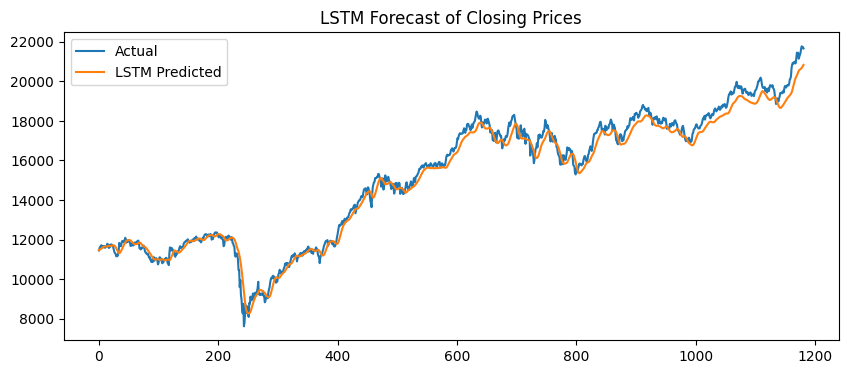

In [ ]:
close_data = df[['Close']].values
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_data)

def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_dataset(scaled_close)
X_train_lstm, X_test_lstm = X_lstm[:int(len(X_lstm)*0.8)], X_lstm[int(len(X_lstm)*0.8):]
y_train_lstm, y_test_lstm = y_lstm[:int(len(y_lstm)*0.8)], y_lstm[int(len(y_lstm)*0.8):]

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=0)

predicted = model.predict(X_test_lstm)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test_lstm)

# Evaluation
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, predicted_prices)

print("📉 LSTM Evaluation:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(10,4))
plt.plot(actual_prices, label='Actual')
plt.plot(predicted_prices, label='LSTM Predicted')
plt.title("LSTM Forecast of Closing Prices")
plt.legend()
plt.show()
